In [1]:
import os
import sys
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.contrib import slim
print(tf.__version__)

from datasets import mnist
from datasets import dataset_utils
from models import lenet

%matplotlib inline  

Instructions for updating:
Use the retry module or similar alternatives.
1.6.0-rc1


In [2]:
_RANDOM_SEED = 0
_NUM_VALIDATION = 6300

class ImageReader(object):
    def __init__(self):
        # Initializes function that decodes RGB JPEG data.
        self._decode_jpeg_data = tf.placeholder(dtype=tf.string)
        self._decode_jpeg = tf.image.decode_jpeg(self._decode_jpeg_data, channels=3)

    def read_image_dims(self, sess, image_data):
        image = self.decode_jpeg(sess, image_data)
        return image.shape[0], image.shape[1]

    def decode_jpeg(self, sess, image_data):
        image = sess.run(self._decode_jpeg,
                     feed_dict={self._decode_jpeg_data: image_data})
        assert len(image.shape) == 3
        assert image.shape[2] == 3
        return image

def _get_filenames_and_classes(dataset_dir):
    directories = []
    class_names = []
    for filename in os.listdir(dataset_dir):
        path = os.path.join(dataset_dir, filename)
        if os.path.isdir(path):
            directories.append(path)
            class_names.append(filename)

    photo_filenames = []
    for directory in directories:
        for filename in os.listdir(directory):
            path = os.path.join(directory, filename)
            photo_filenames.append(path)

    return photo_filenames, sorted(class_names)

def _dataset_exists(dataset_dir):
    for split_name in ['train', 'validation']:
        output_filename = _get_dataset_filename(dataset_dir, split_name)
        if not tf.gfile.Exists(output_filename):
            return False
    return True


def _get_dataset_filename(dataset_dir, split_name):
    output_filename = 'mnist_%s.tfrecord' % (split_name)
    return os.path.join(dataset_dir, output_filename)


def _convert_dataset(split_name, filenames, class_names_to_ids, dataset_dir):
    assert split_name in ['train', 'validation']

    with tf.Graph().as_default():
        image_reader = ImageReader()

        with tf.Session('') as sess:
            output_filename = _get_dataset_filename(dataset_dir, split_name)
            with tf.python_io.TFRecordWriter(output_filename) as tfrecord_writer:
                files_written=0
                for filename in filenames:
                    image_data = tf.gfile.FastGFile(filename, 'rb').read()
                    height, width = image_reader.read_image_dims(sess, image_data)

                    class_name = os.path.basename(os.path.dirname(filename))
                    class_id = class_names_to_ids[class_name]

                    example = dataset_utils.image_to_tfexample(image_data, b'jpg', height, width, class_id)
                    tfrecord_writer.write(example.SerializeToString())
                    files_written+=1
                print('%d files written for %s' % (files_written, split_name))
                    
def run(dataset_dir):
    if not tf.gfile.Exists(dataset_dir):
        tf.gfile.MakeDirs(dataset_dir)

    if _dataset_exists(dataset_dir):
        print('Dataset files already exist. Exiting without re-creating them.')
        return

    #dataset_utils.download_and_uncompress_tarball(_DATA_URL, dataset_dir)
    photo_filenames, class_names = _get_filenames_and_classes(dataset_dir)
    class_names_to_ids = dict(zip(class_names, range(len(class_names))))

    # Divide into train and test:
    random.seed(_RANDOM_SEED)
    random.shuffle(photo_filenames)
    training_filenames = photo_filenames[_NUM_VALIDATION:]
    validation_filenames = photo_filenames[:_NUM_VALIDATION]

    # First, convert the training and validation sets.
    _convert_dataset('train', training_filenames, class_names_to_ids,
                   dataset_dir)
    _convert_dataset('validation', validation_filenames, class_names_to_ids,
                   dataset_dir)

    # Finally, write the labels file:
    labels_to_class_names = dict(zip(range(len(class_names)), class_names))
    dataset_utils.write_label_file(labels_to_class_names, dataset_dir)
    return training_filenames, validation_filenames, class_names_to_ids

In [3]:
dataset_dir = "./data/mnist/trainingSet"
training_filenames, validation_filenames, class_names_to_ids = run(dataset_dir)

35700 files written for train
6300 files written for validation


In [4]:
def preprocess_image(image, output_height, output_width, is_training):
    image = tf.to_float(image)
    image = tf.image.resize_image_with_crop_or_pad(image, output_width, output_height)
    image = tf.subtract(image, 128.0)
    image = tf.div(image, 128.0)
    return image

def load_batch(dataset, batch_size=32, height=28, width=28, is_training=False):
    data_provider = slim.dataset_data_provider.DatasetDataProvider(dataset)

    image, label = data_provider.get(['image', 'label'])

    image = preprocess_image(image, height, width, is_training)

    images, labels = tf.train.batch(
        [image, label],
        batch_size=batch_size,
        allow_smaller_final_batch=True)

    return images, labels

def train(dataset_dir, batch_size, log_dir, num_steps):
    # load the dataset
    dataset = mnist.get_split('train', dataset_dir)

    # load batch of dataset
    images, labels = load_batch(dataset, batch_size, is_training=True)

    # run the image through the model
    logits, endpoints = lenet.lenet(images, num_classes=10, is_training=True,
          dropout_keep_prob=0.5)

    # get the cross-entropy loss
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()
    tf.summary.scalar('loss', total_loss)

    # use RMSProp to optimize
    optimizer = tf.train.RMSPropOptimizer(0.001, 0.9)

    # create train op
    train_op = slim.learning.create_train_op(total_loss, optimizer, summarize_gradients=True)

    # run training
    slim.learning.train(train_op, log_dir, save_summaries_secs=10, number_of_steps=num_steps)

In [5]:
num_steps = 1000
train(dataset_dir, 32, './output', num_steps)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path ./output/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:ten

INFO:tensorflow:global step 85: loss = 1.0132 (0.064 sec/step)
INFO:tensorflow:global step 86: loss = 0.8851 (0.061 sec/step)
INFO:tensorflow:global step 87: loss = 1.1929 (0.060 sec/step)
INFO:tensorflow:global step 88: loss = 1.0451 (0.063 sec/step)
INFO:tensorflow:global step 89: loss = 1.0134 (0.063 sec/step)
INFO:tensorflow:global step 90: loss = 0.6473 (0.065 sec/step)
INFO:tensorflow:global step 91: loss = 0.8162 (0.064 sec/step)
INFO:tensorflow:global step 92: loss = 0.9880 (0.065 sec/step)
INFO:tensorflow:global step 93: loss = 0.7412 (0.063 sec/step)
INFO:tensorflow:global step 94: loss = 0.8242 (0.061 sec/step)
INFO:tensorflow:global step 95: loss = 0.5451 (0.060 sec/step)
INFO:tensorflow:global step 96: loss = 0.6160 (0.061 sec/step)
INFO:tensorflow:global step 97: loss = 0.6727 (0.058 sec/step)
INFO:tensorflow:global step 98: loss = 0.7503 (0.059 sec/step)
INFO:tensorflow:global step 99: loss = 0.6028 (0.058 sec/step)
INFO:tensorflow:global step 100: loss = 0.6022 (0.059 s

INFO:tensorflow:global step 212: loss = 0.0903 (0.060 sec/step)
INFO:tensorflow:global step 213: loss = 0.1251 (0.061 sec/step)
INFO:tensorflow:global step 214: loss = 0.1224 (0.062 sec/step)
INFO:tensorflow:global step 215: loss = 0.0883 (0.060 sec/step)
INFO:tensorflow:global step 216: loss = 0.1462 (0.060 sec/step)
INFO:tensorflow:global step 217: loss = 0.2856 (0.060 sec/step)
INFO:tensorflow:global step 218: loss = 0.5498 (0.066 sec/step)
INFO:tensorflow:global step 219: loss = 0.0725 (0.064 sec/step)
INFO:tensorflow:global step 220: loss = 0.4669 (0.061 sec/step)
INFO:tensorflow:global step 221: loss = 0.0583 (0.060 sec/step)
INFO:tensorflow:global step 222: loss = 0.1096 (0.061 sec/step)
INFO:tensorflow:global step 223: loss = 0.0606 (0.059 sec/step)
INFO:tensorflow:global step 224: loss = 0.1674 (0.061 sec/step)
INFO:tensorflow:global step 225: loss = 0.2845 (0.060 sec/step)
INFO:tensorflow:global step 226: loss = 0.1860 (0.061 sec/step)
INFO:tensorflow:global step 227: loss = 

INFO:tensorflow:global step 339: loss = 0.0247 (0.066 sec/step)
INFO:tensorflow:global step 340: loss = 0.1069 (0.066 sec/step)
INFO:tensorflow:global step 341: loss = 0.0059 (0.068 sec/step)
INFO:tensorflow:global step 342: loss = 0.1393 (0.071 sec/step)
INFO:tensorflow:global step 343: loss = 0.3314 (0.064 sec/step)
INFO:tensorflow:global step 344: loss = 0.2445 (0.059 sec/step)
INFO:tensorflow:global step 345: loss = 0.1929 (0.064 sec/step)
INFO:tensorflow:global step 346: loss = 0.0143 (0.063 sec/step)
INFO:tensorflow:global step 347: loss = 0.1644 (0.061 sec/step)
INFO:tensorflow:global step 348: loss = 0.0141 (0.063 sec/step)
INFO:tensorflow:global step 349: loss = 0.3578 (0.065 sec/step)
INFO:tensorflow:global step 350: loss = 0.2621 (0.064 sec/step)
INFO:tensorflow:global step 351: loss = 0.2615 (0.062 sec/step)
INFO:tensorflow:global step 352: loss = 0.0988 (0.066 sec/step)
INFO:tensorflow:global step 353: loss = 0.0747 (0.071 sec/step)
INFO:tensorflow:global step 354: loss = 

INFO:tensorflow:global step 467: loss = 0.0282 (0.061 sec/step)
INFO:tensorflow:global step 468: loss = 0.1310 (0.086 sec/step)
INFO:tensorflow:global step 469: loss = 0.0502 (0.057 sec/step)
INFO:tensorflow:Recording summary at step 469.
INFO:tensorflow:global step 470: loss = 0.0082 (0.060 sec/step)
INFO:tensorflow:global step 471: loss = 0.0436 (0.053 sec/step)
INFO:tensorflow:global step 472: loss = 0.0987 (0.053 sec/step)
INFO:tensorflow:global step 473: loss = 0.1469 (0.054 sec/step)
INFO:tensorflow:global step 474: loss = 0.0560 (0.055 sec/step)
INFO:tensorflow:global step 475: loss = 0.0557 (0.054 sec/step)
INFO:tensorflow:global step 476: loss = 0.4613 (0.055 sec/step)
INFO:tensorflow:global step 477: loss = 0.1594 (0.053 sec/step)
INFO:tensorflow:global step 478: loss = 0.1222 (0.055 sec/step)
INFO:tensorflow:global step 479: loss = 0.0795 (0.055 sec/step)
INFO:tensorflow:global step 480: loss = 0.0238 (0.053 sec/step)
INFO:tensorflow:global step 481: loss = 0.0149 (0.055 sec

INFO:tensorflow:global step 595: loss = 0.0964 (0.055 sec/step)
INFO:tensorflow:global step 596: loss = 0.0432 (0.056 sec/step)
INFO:tensorflow:global step 597: loss = 0.2705 (0.056 sec/step)
INFO:tensorflow:global step 598: loss = 0.5844 (0.053 sec/step)
INFO:tensorflow:global step 599: loss = 0.0100 (0.053 sec/step)
INFO:tensorflow:global step 600: loss = 0.0600 (0.054 sec/step)
INFO:tensorflow:global step 601: loss = 0.1099 (0.055 sec/step)
INFO:tensorflow:global step 602: loss = 0.4345 (0.053 sec/step)
INFO:tensorflow:global step 603: loss = 0.0173 (0.054 sec/step)
INFO:tensorflow:global step 604: loss = 0.0450 (0.054 sec/step)
INFO:tensorflow:global step 605: loss = 0.0354 (0.053 sec/step)
INFO:tensorflow:global step 606: loss = 0.0082 (0.054 sec/step)
INFO:tensorflow:global step 607: loss = 0.0283 (0.055 sec/step)
INFO:tensorflow:global step 608: loss = 0.0163 (0.053 sec/step)
INFO:tensorflow:global step 609: loss = 0.0578 (0.053 sec/step)
INFO:tensorflow:global step 610: loss = 

INFO:tensorflow:global step 722: loss = 0.0006 (0.054 sec/step)
INFO:tensorflow:global step 723: loss = 0.0061 (0.054 sec/step)
INFO:tensorflow:global step 724: loss = 0.0468 (0.054 sec/step)
INFO:tensorflow:global step 725: loss = 0.0029 (0.054 sec/step)
INFO:tensorflow:global step 726: loss = 0.0416 (0.055 sec/step)
INFO:tensorflow:global step 727: loss = 0.0592 (0.054 sec/step)
INFO:tensorflow:global step 728: loss = 0.1885 (0.054 sec/step)
INFO:tensorflow:global step 729: loss = 0.0970 (0.054 sec/step)
INFO:tensorflow:global step 730: loss = 0.2546 (0.055 sec/step)
INFO:tensorflow:global step 731: loss = 0.3058 (0.057 sec/step)
INFO:tensorflow:global step 732: loss = 0.0235 (0.054 sec/step)
INFO:tensorflow:global step 733: loss = 0.0818 (0.055 sec/step)
INFO:tensorflow:global step 734: loss = 0.0149 (0.054 sec/step)
INFO:tensorflow:global step 735: loss = 0.0003 (0.054 sec/step)
INFO:tensorflow:global step 736: loss = 0.2463 (0.055 sec/step)
INFO:tensorflow:global step 737: loss = 

INFO:tensorflow:global step 849: loss = 0.0031 (0.053 sec/step)
INFO:tensorflow:global step 850: loss = 0.0013 (0.056 sec/step)
INFO:tensorflow:global step 851: loss = 0.0810 (0.056 sec/step)
INFO:tensorflow:global step 852: loss = 0.0631 (0.054 sec/step)
INFO:tensorflow:global step 853: loss = 0.1777 (0.054 sec/step)
INFO:tensorflow:global step 854: loss = 0.0402 (0.055 sec/step)
INFO:tensorflow:global step 855: loss = 0.0217 (0.055 sec/step)
INFO:tensorflow:global step 856: loss = 0.1184 (0.053 sec/step)
INFO:tensorflow:global step 857: loss = 0.0326 (0.055 sec/step)
INFO:tensorflow:global step 858: loss = 0.1080 (0.053 sec/step)
INFO:tensorflow:global step 859: loss = 0.0314 (0.054 sec/step)
INFO:tensorflow:global step 860: loss = 0.0060 (0.054 sec/step)
INFO:tensorflow:global step 861: loss = 0.0066 (0.056 sec/step)
INFO:tensorflow:global step 862: loss = 0.0066 (0.055 sec/step)
INFO:tensorflow:global step 863: loss = 0.0394 (0.054 sec/step)
INFO:tensorflow:global step 864: loss = 

INFO:tensorflow:global step 978: loss = 0.0101 (0.056 sec/step)
INFO:tensorflow:global step 979: loss = 0.0697 (0.057 sec/step)
INFO:tensorflow:global step 980: loss = 0.0497 (0.054 sec/step)
INFO:tensorflow:global step 981: loss = 0.2016 (0.055 sec/step)
INFO:tensorflow:global step 982: loss = 0.0213 (0.054 sec/step)
INFO:tensorflow:global step 983: loss = 0.1504 (0.055 sec/step)
INFO:tensorflow:global step 984: loss = 0.0181 (0.055 sec/step)
INFO:tensorflow:global step 985: loss = 0.1065 (0.054 sec/step)
INFO:tensorflow:global step 986: loss = 0.0629 (0.058 sec/step)
INFO:tensorflow:global step 987: loss = 0.0025 (0.058 sec/step)
INFO:tensorflow:global step 988: loss = 0.0093 (0.057 sec/step)
INFO:tensorflow:global step 989: loss = 0.0125 (0.056 sec/step)
INFO:tensorflow:global_step/sec: 17.2048
INFO:tensorflow:global step 990: loss = 0.0751 (0.085 sec/step)
INFO:tensorflow:global step 991: loss = 0.1908 (0.063 sec/step)
INFO:tensorflow:global step 992: loss = 0.1580 (0.056 sec/step)

In [6]:
def freeze_graph(model_dir, output_node_names):
    """Extract the sub graph defined by the output nodes and convert 
    all its variables into constant 
    Args:
        model_dir: the root folder containing the checkpoint state file
        output_node_names: a string, containing all the output node's names, 
                            comma separated
    """
    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            "directory: %s" % model_dir)

    if not output_node_names:
        print("You need to supply the name of a node to --output_node_names.")
        return -1

    # We retrieve our checkpoint fullpath
    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path
    
    # We precise the file fullname of our freezed graph
    absolute_model_dir = "/".join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + "/frozen_model.pb"

    # We clear devices to allow TensorFlow to control on which device it will load operations
    clear_devices = True

    # We start a session using a temporary fresh Graph
    with tf.Session(graph=tf.Graph()) as sess:
        # We import the meta graph in the current default Graph
        saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

        # We restore the weights
        saver.restore(sess, input_checkpoint)
        
        # We use a built-in TF helper to export variables to constants
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess, # The session is used to retrieve the weights
            tf.get_default_graph().as_graph_def(), # The graph_def is used to retrieve the nodes 
            output_node_names.split(",") # The output node names are used to select the usefull nodes
        ) 

        # Finally we serialize and dump the output graph to the filesystem
        with tf.gfile.GFile(output_graph, "wb") as f:
            f.write(output_graph_def.SerializeToString())
        print("%d ops in the final graph." % len(output_graph_def.node))

    return output_graph_def

In [7]:
model_dir = './output'
output_node_names = 'Predictions/Softmax'
lenet_graph = freeze_graph(model_dir, output_node_names)

INFO:tensorflow:Restoring parameters from ./output/model.ckpt-1000
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.
55 ops in the final graph.


In [8]:
MODEL_FILE = "./output/frozen_model.pb"

lenet_graph = tf.Graph()
with lenet_graph.as_default():
    lenet_graph_def = tf.GraphDef()
    with tf.gfile.GFile(MODEL_FILE, 'rb') as fid:
        serialized_graph = fid.read()
        lenet_graph_def.ParseFromString(serialized_graph)            
        tf.import_graph_def(lenet_graph_def, name='')
        
        sess = tf.Session()
        with sess.as_default():
            net = lambda img : sess.run(('Predictions/Softmax:0'), feed_dict={'batch:0':img})  

In [12]:
total_validation = len(validation_filenames)
validationIx = 0

image_data = np.zeros((total_validation, 28, 28, 3))
image_class_ids = np.zeros(total_validation)

for filename in validation_filenames:
    image = cv2.imread(filename, 1)
    image_data[validationIx, :, :, :] = image

    class_name = os.path.basename(os.path.dirname(filename))
    image_class_ids[validationIx] = class_names_to_ids[class_name]

    validationIx += 1
    
predictions = net(image_data)
prediction = np.argmax(predictions, axis=1)

In [13]:
success = np.sum(prediction == image_class_ids)
accuracy = float(success) / float(prediction.shape[0])
print(success)
print(accuracy)

5868
0.931428571429


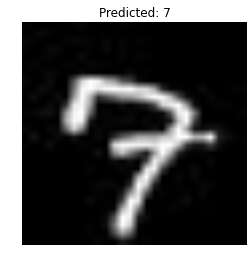

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [11]:
image = cv2.imread('./data/mnist/testSet/img_6.jpg', 1)
image_data = np.expand_dims(image, axis=0)
predictions = net(image_data)
prediction = np.argmax(predictions)

# Plot Image
plt.figure()
plt.imshow(image)
plt.title('Predicted: %d' % (prediction))
plt.axis('off')
plt.show()

print(predictions)